In [91]:
#!curl https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py

In [32]:
#!pipenv install seaborn 

In [265]:
#!pipenv install spacy

In [269]:
#!python -m spacy download en_core_web_sm


In [61]:
from bs4 import BeautifulSoup
import glob
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
# import tqdm
from tqdm.auto import tqdm
#pd.set_option('display.max_colwidth', None)




## Step 1: Prepare documents (Extracting and Transforming)

## Ingestion
This was extracted from telegram channel conversation (from 14-2-2019 to 14-9-2024) on diet and the data was in form of many html documents.

In [106]:
# Load HTML files
def wrangle(paths):
    dfs=[]
    # forward fill after removed text from date column
    def clean_date(date):
                # Regular expression pattern for valid dates (e.g., '13 March 2019')
                pattern = r'^\d{1,2}\s\w+\s\d{4}$'  # Matches 'DD Month YYYY'
                if re.match(pattern, date):
                    return date
                else:
                    return None  # Replace invalid dates with None
    
    for html in paths:
        
        with open( html, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')
    
            # Extract messages
            messages = []
            for message in soup.find_all('div', class_='message'):
                date = message.find('div', class_='body details').text.strip() if message.find('div', class_='body details') else None
                time = message.find('div', class_='date').text.strip() if message.find('div', class_='date') else None
                user = message.find('div', class_='from_name').text.strip() if message.find('div', class_='from_name') else None
                content = message.find('div', class_='text').text.strip() if message.find('div', class_='text') else None
                messages.append({"Date":date, "Time":time, "User": user,"Content": content})
            
            # Convert to DataFrame
            df = pd.DataFrame(messages)
            # fill in the na values by forward fill for dates
            df['Date']=df['Date'].ffill()
            # transform the date column by replacing any message about 'someone invited someone' in the group or removed someone with none
            df['Date']=df['Date'].apply(clean_date)
            df['Date']=df['Date'].ffill()
            # drop rows that have three nans. It is the date heading
            df=df.dropna(thresh=2)
            # forward fill user where nan
            df['User']=df['User'].ffill()
            # drop empty content it is usually pics
            df=df.dropna(subset='Content')
            dfs.append(df)
            print(df.head(1))
            
    return dfs

In [107]:
# file pattern
file_pattern=r'C:\Users\user\Documents\LLM Zoomcamp\Project\data\raw_data\messages*.html'

In [118]:
# Get a list of all matching files
files = glob.glob(file_pattern)  # we matched 438 files
len(files)
# for f in files:
#     print(f)

438

In [147]:
import time

t0 = time.time()
# Import html files using wrangle function, transform and combine them
#dfs=wrangle(files)
t1 = time.time()
total = t1-t0
# concat dataframes
#df=pd.concat(dfs, ignore_index=True)

df=df.dropna()
# Save to CSV
# df.to_csv('../data/clean_data/combo_conversations_latest.csv', index=False)
# df.isnull().sum()

In [148]:
print(total/60)

0.0


In [185]:
# import csv file
df = pd.read_csv('../data/clean_data/combo_conversations_latest.csv', parse_dates=['Date'])
#df.info()
df['Date']

0        2019-02-14
1        2019-02-14
2        2019-02-14
3        2019-02-14
4        2019-02-14
            ...    
414123   2021-04-28
414124   2021-04-28
414125   2021-04-28
414126   2021-04-28
414127   2021-04-28
Name: Date, Length: 414128, dtype: datetime64[ns]

In [186]:
df.head()

,Date,Time,User,Content
0,2019-02-14,08:02,Silmavi,Hello!
1,2019-02-14,08:05,Deleted Account,"sooo, detox finished when? 😄"
2,2019-02-14,08:05,Silmavi,Here we can talk about Aajonus?
3,2019-02-14,08:07,Deleted Account,Detox! Hell yeah Aajonus
4,2019-02-14,08:08,Silmavi,😂😂😂😂


In [187]:
# Set the 'Date' column as the index of the DataFrame
df.set_index('Date', inplace=True)
# Sort the DataFrame by the index (Date) so that there is good flow in a chronological order.
df.sort_index(inplace=True)
df.head()

,Time,User,Content
Date,,,
2019-02-14,08:02,Silmavi,Hello!
2019-02-14,15:40,Silmavi,when you eat it alone?
2019-02-14,15:42,Silmavi,Good idea to eat it once wuth honey and once a...
2019-02-14,15:43,Silmavi,My kids eat it with the meal.They aren't at ho...
2019-02-14,15:43,Silmavi,I will do it during week end


In [191]:
# slice the data and keep the last year only
df_slice = df.loc['2024-01-01':'2024-09-14', 'Content']
#print(df_slice.info())
df_slice.head()

df_slice

Date
2024-01-01    this is the first I see an egg in bath ingredi...
2024-01-01                                             and egg?
2024-01-01    The plastic might even be better (especially i...
2024-01-01                                            Your love
2024-01-01    Better anything non processed.Sea water, an eg...
                                    ...                        
2024-09-14                    are wild animals safe to eat raw?
2024-09-14    I saw this on eat raw meat channel. I wouldn’t...
2024-09-14    You got vaxxed even after listening to aajonus...
2024-09-14    Is it possible for a detox to last 4 months or...
2024-09-14    What to do with 10L of raw milk that are alrea...
Name: Content, Length: 44742, dtype: object

In [192]:
import pandas as pd
import re
# split whenever there is ?, !, or . plus a space
def split_into_sentences(text):
    sentences = re.split(r'(?<=[.!?])\s*', text)
    return sentences


In [194]:
# Converting the dataframe to a long text form to chunk
text = " ".join(df_slice)

# Chunking into 5-sentence parts
#sentences = text.split(". ")
sentences=split_into_sentences(text)
chunks = ['. '.join(sentences[i:i+5]) for i in range(0, len(sentences), 5)]
print(type(chunks))
print(len(chunks))

df_chunks=pd.DataFrame(chunks)
df_chunks.reset_index(inplace=True)
df_chunks.rename(columns={'index':'id',0:'content'}, inplace=True)

df_chunks

<class 'list'>
5837


,id,content
0,0,this is the first I see an egg in bath ingredi...
1,1,My husband is going through his first vomit/di...
2,2,"На вкус как жареные грибы, кисловатые.. Чувств..."
3,3,"Это я с бухты барахты приготовил и пробую, а к..."
4,4,"Juice of lemon, naturally sparkling water, hon..."
...,...,...
5832,5832,The most effective is stone dry which you grat...
5833,5833,- Modalities and frequency to start taking bat...
5834,5834,You will get much better guidance here for fre...
5835,5835,"Ofc cheese And drink it, a lots of bacteria Wh..."


In [195]:
# Count the numbers of sentences per row
#df_chunks['number of sentences']=[len(x) for x in df_chunks['content'].apply(split_into_sentences)]
df_chunks['number of sentences']=[len(x.split('. ')) for x in df_chunks['content']]
df_chunks['number of words']=[len(x.split()) for x in df_chunks['content']]

# get all information about the spread of the number of sentences
print(df_chunks['number of sentences'].describe())  # mean is 5 sentences
df_chunks['number of words'].describe()

count    5837.000000
mean        4.999829
std         0.013089
min         4.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: number of sentences, dtype: float64


count    5837.000000
mean       99.314203
std        64.495198
min         5.000000
25%        57.000000
50%        86.000000
75%       122.000000
max       671.000000
Name: number of words, dtype: float64

In [197]:
# drop all content with 
df_chunks[
    df_chunks['number of sentences']==5

]['number of words'].count()

5836

In [198]:
# drop all content with 
df_chunks[
    df_chunks['number of words']>1000

]['number of words'].count()

0

### Compare the three methods:
- Taking the raw conversations was not the best option as each chunk was too short to get context
- Threaded chunks by grouping each user speech would less context and would not link each question to its relevant answer
- Grouping questions with their answer was the best option since the aim was for this to be health adviser.

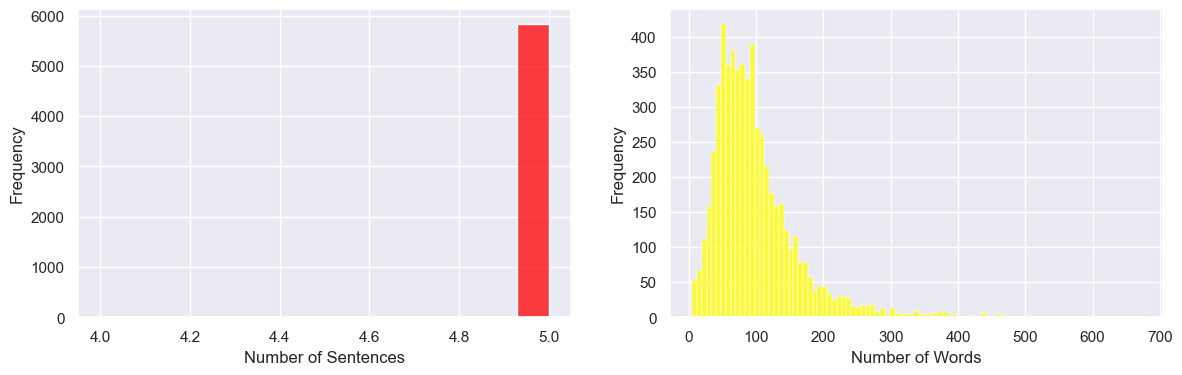

In [200]:
# number of sentences and words per chunk
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(14,4))

sns.histplot(data=df_chunks, x='number of sentences',color="red", ax=axs[0])
sns.histplot(data=df_chunks, x='number of words',color='yellow', ax=axs[1])
# # Adding labels and legend
# Set label for x-axis 
axs[0].set_xlabel( "Number of Sentences" , size = 12 ) 
axs[1].set_xlabel( "Number of Words" , size = 12 ) 
# Set label for y-axis 
axs[0].set_ylabel( "Frequency" , size = 12 ) 
axs[1].set_ylabel( "Frequency" , size = 12 ) 
  

# Display figure 
plt.show() 



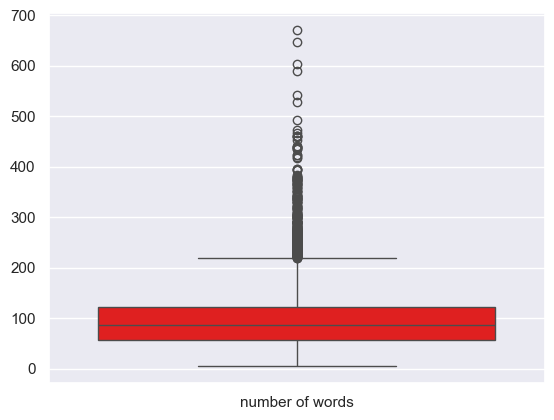

In [202]:
#sns.boxplot(data=chunked_QandA, x='number of sentences')
sns.boxplot(data=df_chunks[['number of words']],color="red")
# Display the plot
plt.show()

#### Amending the chunk sizes
This is important because different has limit of number of token it can handle
Model Context Window: Most transformer-based models, like GPT-3, have a context window that limits the number of tokens (words, punctuation marks, etc.)
they can process at once. For example, GPT-3 has a context window of around 4,000 tokens, 
while smaller models like GPT-2 might have around 1,024 tokens.
Comparison between using
sentences = re.split(r'(?<=[.!?]) +', text)  this one broken sentences if there was a punctuation and one or more spaces after
or sentences = re.split(r'(?<=[.!?])\s*', text) this one broke sentence where there was only one of the punctuation marks with or without spaces after.
I decided to choose the first method because the second method was one word quotes as two senteces. For examples 'How?' was counted as two sentences.
'I said.....' was counted as few sentences. Now min number of sentences will be 3 and maximum will be 50.

In [213]:
# examine the longest sentence
with pd.option_context('display.max_colwidth', None):
  display(df_chunks[df_chunks['number of sentences']==4][['content', 'number of words']])

,content,number of words
5836,"Is it possible for a detox to last 4 months or more, with symptoms such as fatigue, mental confusion, general malaise and daily aches and pains?. What to do with 10L of raw milk that are already a bit over 3 weeks old and quite fermented?. (kept in the fridge, but fridge has fluctuating temperature)Anybody tried making cheese from old fermented milk?.",62


In [216]:
# examine the chunk with highest number of words
with pd.option_context('display.max_colwidth', None):
  display(df_chunks[df_chunks['number of words']==100][['content','number of sentences']])

,content,number of sentences
387,"I'm a very real person fishies Yeah, exactly eskimo food What can I use instead of sunscreen?. Hmm What about frozen meat, frozen butter, etc And what's the problem with detoxxing too much right away?. Wouldn't the detox end sooner the harder you do it?. Never had it before I have some beef in a closed jar for a week How long should high meat be aired for and how long does it take to be good enough to eat?. thanks for the info guys - will avoid doing this from now on Yea more than 35g in one scoop.",5
466,si=JV_TDBWeiKvkzNUTHe starts talking about the Italian water quality chart at 5:55.. He says the levels of radioactive material in pellegrino are very high.. I would stop drinking it.. 😂 Fuck I love my Pellie with lemon😭 Results dont lie tho @perryayin regarding your hair test maybe your body is doing a great job of dealing with it n getting rid of it but look into mountain valley spring water or smth else I guess shitty CO2 in mountain valley would be better than a nuclear isotope huh?. Lmao I like carbonation😅 What do you guys think about Mary’s organic chicken?,5
576,For how long do you age it?. We truly live in a completely different reality from these slaves Yet that same idiot that uses these disgusting chemical products will probably think raw food smells bad This is the one problem I can't figure out how to solve.. I become so angry when some idiot that uses an estrogenic perfume contaminates the whole area with it Most natural food became illegal whenever germ theory took over the world anyway so it couldn't be illegal prior to that.. Thanks.. I think my eardrum is ruptured so I just give up That's sucks.,5
822,"I have a well If I’m making a lube to last for a whole day, how long under room temperature will it last until goes bad.. I’d assume it won’t go bad but I’m not sure.. if anyone else is such a liability they can show themselves now, I will remove too can you share the recipe?. Dude just use ur hands Genius, free too ya ferment the leaves beforehand We chatted for a bit even I have proof Me too im not joking, but I think he might still be alive.. he must have been surrounded by women huh?",5
1184,"Angel wdyt that clear lens are not going to help.. I've seen people light UV flashlight through it and i came out as a white color kind, so apparently it reduces the spectrum What kind of juicer did you use?. Yea The rest is fibre The brown thing is pure juice that happened to mine too but when I shook it up it went back to what looked like normal Celery juice made yesterday, is this brown thing normal?. Probably the elite bloodlines did gmo inbreeding with them for this reason.. Shapeshifting reptilians Was just wondering Anyone eaten raw lizard?",5
1196,"Aajonus did say the sodium content has something to do with it.. But that's not all, either certain nutrients or the specific combination of them cannot be replaced It's the main food to cleanse the blood.. I'm not sure if any other food does that No, there is no full replacement, except sugar cane juice.. Best second things are the ones you mention, especially sports formula, which adds tomato and other ingredients, but still not a full replacement at all Are there any alkalizing replacements for celery juice in its absence?. Maybe mineral water, ACV and lemon to stimulate digestion?",5
1281,"I kept talking to him to keep him pacified, I found that the best way to keep things under control.. It was an enormous relief to me when he met in person with his now “wife” because he finally left me alone (for the most part).. You are all only safe here because we take all the hits from them what am i reading Ikr.. Cringe Primal ppl like that = skill issues Why is bro harassing Rose Dont bring her into this shit Just so I understand correctly, you willingly put naked photos of yourself on the internet?. No.",5
1312,"So the detoxification pathways must be opened.. Eating high amounts of raw fat dissolve toxins and neutralizes them so that t

In [225]:
# drop anything below 100 words or  above 400 words
df=df_chunks[
  
  (df_chunks['number of words']>100) & (df_chunks['number of words']<400) 

]


In [226]:
df

,id,content,number of sentences,number of words
3,3,"Это я с бухты барахты приготовил и пробую, а к...",5,204
4,4,"Juice of lemon, naturally sparkling water, hon...",5,150
7,7,Someone know something about it ?. I drank it ...,5,108
9,9,my name says it all tbh Hey Daniel welcome to ...,5,229
10,10,I'm trying to lose fat Why do you think herbiv...,5,164
...,...,...,...,...
5827,5827,Aajonus mentionned in an interview that he did...,5,153
5828,5828,It is probably lighter if you werent toxic Tha...,5,172
5832,5832,The most effective is stone dry which you grat...,5,104
5833,5833,- Modalities and frequency to start taking bat...,5,216


In [227]:
# create documents
documents =df.to_dict(orient='records')

In [228]:
documents[0]

{'id': 3,
 'content': "Это я с бухты барахты приготовил и пробую, а кому-то может не повезёт.. Я держал печень на дне банки в холодильнике.. Каждые 3-4 дня проветривал.. Особо сильный эффект даёт кровь, но наверное это из-за того что жидкость быстрей всасывается Well you can meditate it is the equivalent of sleeping if you can somehow get your body in an alpha state Some people with brain damage have the sleep center area of their brains shut off, so they just meditate or lay still in darkness and their body is in the equivalent state of sleeping Aajonus says Best things you can do is drink cream and swim in the ocean before sunset The body detoxes from 11pm-5am, its synced up with our circadian rhythm usually So that means we are supposed to just sit in darkness for 5 hours lol Or do anything that requires energy I didn't understand because he said that the nervous system detoxes when the body is completely relaxed so I guess we shouldn't exercise?. Yes It would bind with the poisons 

In [229]:
len(documents)

2190

In [230]:
df_chunks.to_csv('../data/clean_data/date_chunked_5s.csv', index=False)